# Wind Power forecasting for the day-ahead energy market - Data Challenge
by Compagnie Nationale du Rhône, ENS Paris & Collège de France

<p align="center"><img src="https://cap.img.pmdstatic.net/fit/http.3A.2F.2Fprd2-bone-image.2Es3-website-eu-west-1.2Eamazonaws.2Ecom.2Fcap.2F2019.2F10.2F04.2Fea495374-9115-4be7-a91a-e9bc5b305b0b.2Ejpeg/768x432/background-color/ffffff/focus-point/992%2C1086/quality/70/dangereuses-pour-la-sante-peu-ecolo-faut-il-en-finir-avec-les-eoliennes-1352031.jpg" width="600"/></p>

Challenge website: https://challengedata.ens.fr/participants/challenges/34/

The objective is to **design an ML/DL model to predict the hourly electrical production** of six independent wind farms owned by CNR for the day ahead, using multiple Numerical Weather Predictions (NWP) models. This is a **supervised learning problem** based on **multivariate time series**.

This notebook is **fully compatible with Google Colab**, feel free to try it yourself!
https://colab.research.google.com/github/qcha41/wind-power-forecasting-challenge/blob/master/notebook.ipynb

## Overview & Status

- Training of 6 models in parallel with identical architectures (one per wind farm).
- ReLu activation for the last neuron to output a positive (or null) value for the power production.
- Forward chaining cross-validation (on the last 3x10% of the training dataset)

| Steps | Forward chaining<br />cross-validation<br />error (MSE) | Final test error<br />(CAPE) | 
| ----- | ----- | ----- | 
| **Baseline**<br />*(multi-variable linear regression)* | 7.22 | 62.32 |
| **Feature engineering**<br />*(WS,WD)* | 1.71 **(-76.3%)** | 33.43 **(-46.3%)** |
| **Manual shutdown detection** | 1.51 **(-11.6%)** | 33.42 **(-0%)** |
| **Recurrent neural network (RNN)**<br />*(GRU cells)* | 1.44 **(-4.6%)** | 31.24 **(-6.5%)** |

## Notebook setup

First of all, let's import the required libraries and configure the notebook.

In [31]:
# # Google Colab configuration
# !git clone https://github.com/qcha41/wind-power-forecasting-challenge.git
# !pip install urllib3==1.25.4 folium==0.2.1 boto3 mlflow mpld3 --quiet
# %cd wind-power-forecasting-challenge

In [131]:
# Load and configure libraires
import os
import numpy as np
import pandas as pd
from core.plots import *
from core.training import *
from core.data import *
import tensorflow as tf
cross_validations = CrossValidationResults()

## Data
### First exploration

In this challenge, we are provided with a **training dataset** and a **test dataset**.

The **training dataset** is composed of different hourly weather forecasts (X) for a period of 8 consecutive months (from May the 1st of 2018 to January the 15th of 2019), together with the associated observed power production in MW (Y). In the **test dataset**, only predictions are provided for another period of 8 months (January the 16th of 2019 to September the 30rd of 2019). The performance of our model is then evaluated online, by submitting its predictions on the test dataset.

In [33]:
# Load data
# df = core.data.load_data()
# Load data
    # Load raw data from file
x_train = pd.read_csv(f'./data/X_train_v2.csv', index_col=0)
x_test = pd.read_csv(f'./data/X_test_v2.csv', index_col=0)
y_train = pd.read_csv("./data/Y_train_sl9m6Jh.csv", index_col=0)

# Make global dataframe with it
df = pd.concat([x_train, x_test])
df.loc[:, 'Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M')
df.loc[:, 'WF'] = df.WF.apply(lambda x: int(x.strip('WF')))
df.loc[y_train.index, 'Production'] = y_train

A given **training example** is thus composed of :
 - a **target time** (*Time* column) and a **wind farm ID** (*WF* column).
 - several **weather forecasts** for that (*Time*,*WF*) couple, in the form of *runs* (*NWP\<i>_\<HourOfTheRun>_\<DayOfTheRun>_\<Variable>* columns). Each run provides an estimation of a particular weather *Variable*, produced at a given time before the target *Time* (*HourOfTheRun*, *DayOfTheRun*), and coming from a given NWP models (*i*). For instance, the run *NWP1_00h_D-2_U* is estimating the weather variable *U* for a given target *Time* using the first NWP model, and is produced at midnight two days before the target *Time*. 
 - the **observed power production** (*Production* column) for that (*Time*,*WF*) couple.

The runs are coming from 4 different NWP models ($i\in[1,4]$), and are forecasting 4 weather variables at various time:
 
NWP Variable | Prediction description | NWP 1 (hourly) | NWP 2 (every 3 hours) | NWP 3 (every 3 hours) | NWP 4 (hourly)
------ | ----- | ----- | ----- | ----- | -----
Wind speed U,V (m/s) | 10min average [H-10min,H] | x (@100m) | x (@100m) | x (@100m) | x (@10m)
Temperature of air T (m/s) | 1hour average [H-1,H] | x |  | x |
Total cloud cover CLCT (%) | instant value at H | | | | x

Further details about these forecasts can be found on the challenge webpage (link above).

In [34]:
# Display the number of training examples per wind farm
df.assign(training = df.Production.isna(), test = ~df.Production.isna())[['WF','training','test']].groupby('WF').sum()

,training,test
WF,,
1,6190,6239
2,6190,6239
3,6190,6239
4,6190,6239
5,5579,6180
6,6190,6239


### Data reshaping

In order to train a model, we first need to design and shape the training examples that will feed it. In this problem, the learning features are the different weather forecasts, and the target output is the observed power production. 

Here are some characteristics of the NWP forecasts:
 - some NWP models are not forecasting their weather variables hourly.
 - a NWP model is forecasting a given weather variable several times before the target time.

In [35]:
# Some NWP models are not forecasting a given weather variable hourly
df.loc[51:54,['WF','Time']+[f'NWP{i}_00h_D-2_U' for i in range(1,5)]]

,WF,Time,NWP1_00h_D-2_U,NWP2_00h_D-2_U,NWP3_00h_D-2_U,NWP4_00h_D-2_U
ID,,,,,,
51,1,2018-05-03 03:00:00,4.4229,5.5147,3.591494,NaN
52,1,2018-05-03 04:00:00,5.0740,NaN,NaN,NaN
53,1,2018-05-03 05:00:00,5.8899,NaN,NaN,NaN
54,1,2018-05-03 06:00:00,6.1131,5.5901,4.682327,NaN


In [36]:
# For a given target time, a NWP model is forecasting a weather variable several times (at different delays before the target time).
df.loc[51:54,['WF','Time']+[col for col in df.columns if col.startswith('NWP4') and col.endswith('_U')]]

,WF,Time,NWP4_00h_D-2_U,NWP4_12h_D-2_U,NWP4_00h_D-1_U,NWP4_12h_D-1_U,NWP4_00h_D_U,NWP4_12h_D_U
ID,,,,,,,,
51,1,2018-05-03 03:00:00,NaN,5.144098,4.668093,4.295196,4.450514,NaN
52,1,2018-05-03 04:00:00,NaN,4.850463,4.863529,4.295196,4.369153,NaN
53,1,2018-05-03 05:00:00,NaN,4.834910,4.863529,4.292873,3.888633,NaN
54,1,2018-05-03 06:00:00,NaN,4.677517,4.659237,4.220859,3.100145,NaN


My approach to deal with the induced missing values is to **compute a new matrix containing the best weather forecast for each (*WF*, *NWP*, *Variable*) triplet**. In other words, each of these triplet is reduced to only one value. For instance, I will create a new single feature called *NWP4_U* giving the best forecast for the wind component *U* forecasted by the fourth NWP model, using the different forecasts *NWP4_XXh-XXX_U*.

To do that, I am using a **weighted mean of the forecasts with a memory coefficient <img src="https://render.githubusercontent.com/render/math?math=\alpha"/>** as hyperparameter. This allows to make recent forecasts more predominant in the calculation than the older ones. We have then : 

<img src="https://render.githubusercontent.com/render/math?math=V_{best}=\dfrac{\sum_{k=1}^{n}\alpha^{\Delta H_k}\,V_k}{\sum_{k=1}^{n}\alpha^{\Delta H_k}}"/>

where <img src="https://render.githubusercontent.com/render/math?math=V_k"/> is the k-th prediction made for a given triplet, which has been produced <img src="https://render.githubusercontent.com/render/math?math=\Delta H_k"/> hours before the target time. 
<img src="https://render.githubusercontent.com/render/math?math=\alpha"/> is a memory coefficient lying in <img src="https://render.githubusercontent.com/render/math?math=]0,1]"/>, which make the value weight <img src="https://render.githubusercontent.com/render/math?math=\alpha^{\Delta H_k}"/> decaying as the delay <img src="https://render.githubusercontent.com/render/math?math=\Delta H_k"/> increases. If <img src="https://render.githubusercontent.com/render/math?math=\alpha=1"/>, all predictions have the same weight (classic mean). Instead, if <img src="https://render.githubusercontent.com/render/math?math=\alpha"/> tends towards 0, we are just keeping the more recent forecast. 

Let's start with <img src="https://render.githubusercontent.com/render/math?math=\alpha=0.9"/>, meaning that the (H-1) forecast, if existing, has weight 0.9, then the (H-2) forecast has weight <img src="https://render.githubusercontent.com/render/math?math=(0.9)^2=0.81"/>, the (H-12) forecast has weight <img src="https://render.githubusercontent.com/render/math?math=(0.9)^12=0.28"/>, and so on.

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

def calculate_best_forecasts(df, forecast_memory):
    """ Compute and returns the best forecasts dataframe """

    def get_run_infos(run_name):
        """ Returns predictor name and timedelta from run name"""

        predictor = '_'.join(run_name.split('_')[::3])
        run_day_offset_str = run_name.split('_')[2].strip('D')
        run_day_offset = int(run_day_offset_str) if run_day_offset_str != '' else 0
        run_time = int(run_name.split('_')[1].strip('h'))
        timedelta = dt.timedelta(days=run_day_offset, hours=run_time)
        return predictor, timedelta

    def reshape_run_data(run_data):
        """ Returns run data in a dataframe with predictor name, delay and value columns """

        # Preparation
        run_name = [col for col in run_data.columns if col.startswith('NWP')][0]

        # Computing predictor and delay
        predictor, timedelta = get_run_infos(run_name)
        run_data.loc[:, 'predictor'] = predictor
        run_data.Time = pd.to_datetime(df.Time, errors = "coerce")
        update_time = run_data.Time.dt.normalize() + timedelta
        run_data.loc[:, 'delay'] = (run_data.Time - update_time) / pd.Timedelta('1h')

        # Cleaning
        run_data.rename(columns={run_name: 'value'}, inplace=True)
        run_data.drop(columns='Time', inplace=True)
        run_data.dropna(subset=['value'], inplace=True)
        run_data.reset_index(inplace=True)

        return run_data

    # Reshape and concatenate each NWP_run data ( index=[ID,predictor]] , columns=[delay,value] )
    best_forecasts = pd.concat([reshape_run_data(df.loc[:, ['Time', col]])
                                for col in df.columns if col.startswith('NWP')], ignore_index=True)

    # Computing weight and weighted_value
    best_forecasts.loc[:, 'weight'] = forecast_memory ** best_forecasts.delay
    best_forecasts.loc[:, 'weighted_value'] = best_forecasts.weight * best_forecasts.value

    # Computing best forecasts
    gb = best_forecasts.groupby(['ID', 'predictor'])
    best_forecasts = gb.weighted_value.sum() / gb.weight.sum()
    best_forecasts = best_forecasts.unstack(level=-1)

    # Replace initial NWP runs forecasts by the best computed forecasts
    not_nwp_cols = [col for col in df.columns if not col.startswith('NWP')]
    df = pd.concat([df[not_nwp_cols], best_forecasts], axis=1)

    return df

In [38]:
# Compute best weather forecasts
FORECAST_MEMORY = 0.9
df = calculate_best_forecasts(df, FORECAST_MEMORY)
df.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,-14.147946,7.293301,4.442653,-6.936784
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,NaN,NaN,NaN,NaN,NaN,7.110209,4.390377,-7.957995
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,NaN,NaN,NaN,NaN,NaN,5.856893,4.042636,-8.823514
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,-13.881284,6.604385,3.444200,-10.008062


### Data insights & features engineering

**Data interpolation** - Previously, we have drastically reduced the number of original features by making new ones, more meaningful for training the future ML/DL model. But we are still facing missing values, due to the fact that there are no forecasts at all for these weather variable at these times. A fairly straightforward approach here is thus to **linearly interpolate these missing values using the forecasts made for previous and future times**.

In [44]:
def get_nwp_cols(df):
    """ Returns the list of NWP columns in the dataframe """

    return [col for col in df.columns if col.startswith('NWP')]
def interpolate_nans(df):
    """ Interpolate missing values within each Wind farms """

    nwp_cols = get_nwp_cols(df)
    gb = df.groupby('WF')[nwp_cols]
    df.loc[:, nwp_cols] = gb.transform(lambda group: group.interpolate(method='linear', limit_direction='both'))
    return df

# here i used transform, changing the original
# gb.transform(lambda group: group.interpolate(method='linear', limit_direction='both'))

In [45]:
# Interpolate remaining missing values
df = interpolate_nans(df)
df.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,-14.147946,7.293301,4.442653,-6.936784
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,4.691971,-13.172605,286.174177,4.124304,-14.059059,7.110209,4.390377,-7.957995
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,4.355679,-13.411292,286.102325,3.433868,-13.970171,5.856893,4.042636,-8.823514
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,-13.881284,6.604385,3.444200,-10.008062


**Feature engineering** - In order to help the future ML/DL model to understand better the important features of the dataset, we create some of them based on the existing ones:
- Wind speed <img src="https://render.githubusercontent.com/render/math?math=WS=U^2%2BV^2"/>
- Wind direction <img src="https://render.githubusercontent.com/render/math?math=WD=\arctan(U/V)"/>

In [46]:
def append_features(df):
    """ Append wind speed and direction features in the dataframe"""

    nwp_cols = get_nwp_cols(df)
    for NWP_num in set([col.split('_')[0] for col in nwp_cols]):
        df.loc[:, NWP_num + '_WS'] = np.sqrt(df[NWP_num + '_U'] ** 2 + df[NWP_num + '_V'] ** 2)  # Wind speed
        df.loc[:, NWP_num + '_WD'] = np.arctan2(df[NWP_num + '_U'], df[NWP_num + '_V'])  # Wind direction (angle)
    return df

In [47]:
# Feature engineering
df = append_features(df)
df.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,...,NWP4_U,NWP4_V,NWP2_WS,NWP2_WD,NWP1_WS,NWP1_WD,NWP3_WS,NWP3_WD,NWP4_WS,NWP4_WD
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.418362,5.707277,-16.076511,5.028264,-12.933917,286.246029,4.814739,...,4.442653,-6.936784,13.876947,2.770808,17.059519,2.800464,14.944768,2.813573,8.237483,2.571961
52,1,2018-05-03 04:00:00,5.11,288.171439,4.766785,-16.593714,4.691971,-13.172605,286.174177,4.124304,...,4.390377,-7.957995,13.983280,2.799413,17.264808,2.861860,14.651519,2.856243,9.088735,2.637450
53,1,2018-05-03 05:00:00,5.03,287.833780,3.771905,-17.132102,4.355679,-13.411292,286.102325,3.433868,...,4.042636,-8.823514,14.100876,2.827563,17.542411,2.924884,14.386005,2.900571,9.705530,2.711968
54,1,2018-05-03 06:00:00,7.18,287.623275,2.903065,-17.147328,4.019386,-13.649980,286.030473,2.743433,...,3.444200,-10.008062,14.229456,2.855225,17.391338,2.973882,14.149787,2.946472,10.584131,2.810146


**Data insights** - Let's have a quick look on basic dataset statistics.

In [48]:
# Global overview
df.describe()

,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V,NWP2_WS,NWP2_WD,NWP1_WS,NWP1_WD,NWP3_WS,NWP3_WD,NWP4_WS,NWP4_WD
count,37375.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000,73904.000000
mean,1.794234,287.653338,0.799176,-0.673748,0.847446,-0.668736,287.167993,0.915822,-0.733729,53.672749,0.544168,-0.534483,6.239450,0.189175,6.800294,0.093422,6.358751,0.170228,3.827917,0.125168
std,2.250572,7.404481,4.704604,5.961421,4.431141,5.309437,6.576952,4.707196,5.454445,40.762993,2.768421,3.535277,3.171633,1.993815,3.538339,1.998496,3.584901,1.996688,2.467994,2.012028
min,0.000000,268.453621,-17.447130,-26.461466,-16.266398,-21.193405,267.425910,-16.580509,-22.457892,-0.000025,-10.799087,-16.756338,0.021524,-3.141568,0.037488,-3.141561,0.016042,-3.141587,0.005599,-3.141536
25%,0.220000,282.121921,-2.202065,-4.757490,-1.947674,-4.332038,282.393876,-1.927114,-4.291784,4.559112,-1.113495,-2.593685,4.010340,-1.687474,4.345165,-1.905788,3.744846,-1.818468,1.837524,-1.783543
50%,0.950000,287.909855,0.416942,-1.149758,0.435311,-1.094114,287.119600,0.566874,-1.138657,62.053020,0.144523,-0.644725,5.859169,0.325060,6.366604,0.210758,5.871294,0.331411,3.386682,0.180969
75%,2.480000,292.924404,3.796546,3.486347,3.702854,3.053943,291.647537,3.729638,2.907347,96.945087,2.045174,1.567164,7.994815,1.956099,8.704326,1.842855,8.299666,1.935300,5.260399,2.002888
max,13.470000,314.933302,23.154450,18.828161,19.635820,19.687271,309.577817,21.466192,21.699369,100.000000,13.564789,15.128703,22.032588,3.141592,27.147827,3.141463,23.646042,3.141564,17.830326,3.141586


Let's now explore a bit more how the features evolves in time. Note the seasonality in the temperature feature. Unfortunately, this seasonality cannot be removed from the dataset because de training period is too short.

In [83]:
import os
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
sns.plotting_context('notebook', rc={'xtick.labelsize': 12})

def rotate_x_labels(graph):
    """ Rotate the x labels of the given graph """

    for axes in graph.axes.flat:
        plt.setp(axes.xaxis.get_majorticklabels(), rotation=60)
def separate_feature_info(df, run, with_prod=False):
    """ Separate run data (Time, WF, run_value) into (Time, WF, nwp_num, run_value) """

    nwp_num = int(run.split('_')[0].strip('NWP'))
    nwp_var = run.split('_')[1]
    base_columns = [col for col in df.columns if "NWP" not in col and col != "Production"] + [run]
    if with_prod is True:
        base_columns.append("Production")
    df_separated = df[base_columns] \
        .assign(NWP=nwp_num) \
        .rename(columns={run: nwp_var})
    return df_separated

def feature_vs_time(df, nwp_var, title=None, type='lineplot', hue="NWP"):
    """ Plots a given feature as a function of time, grouped by nwp models """

    nwp_runs = [col for col in df.columns if col.startswith('NWP') and col.split('_')[1] == nwp_var]
    df = pd.concat([separate_feature_info(df, run) for run in nwp_runs]).sort_values(by='Time')
    g = sns.FacetGrid(df, col="WF", hue=hue, col_wrap=3)
    g.map(getattr(sns, type), "Time", nwp_var, alpha=0.7)
    g.add_legend()
    rotate_x_labels(g)
    if title is not None:
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(title)
def production_vs_time(df):
    """ Plots the production data as a function of time """
    g = sns.FacetGrid(df, col="WF", col_wrap=3)
    g.map(sns.lineplot, "Time", "Production")
    rotate_x_labels(g)

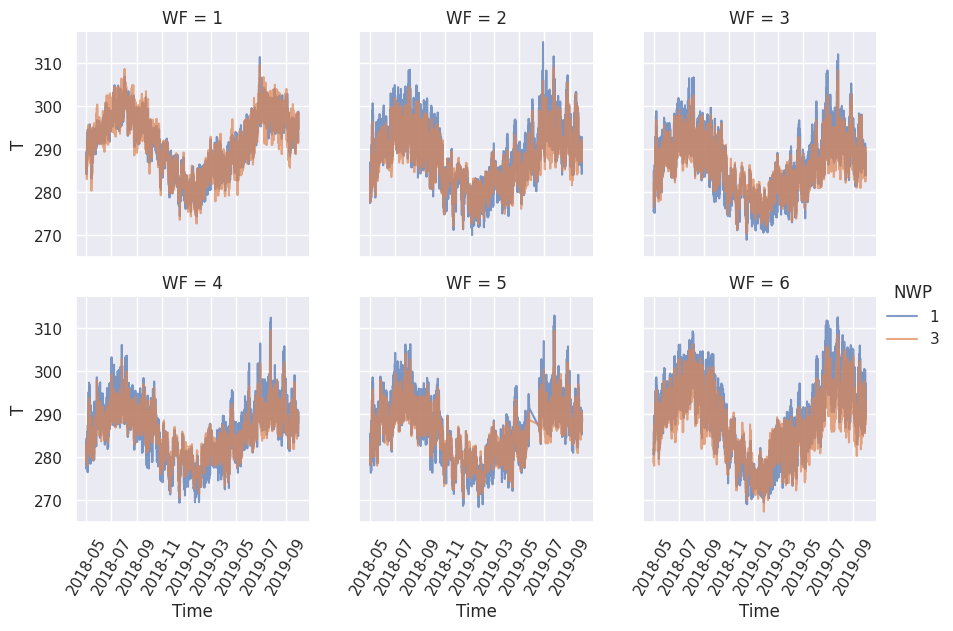

In [81]:
feature_vs_time(df,"T") # Try also with T, U, V, CLCT, WS, WD variables

Let's now explore how the power production (target output) evolves in time for each wind farms. We can see that for instance that the maximal power production authorized is reached in WF1 and WF6, and that this limit is different from a wind farm to another (limited at 10 MW for WF1 and at 4 MW for WF6).

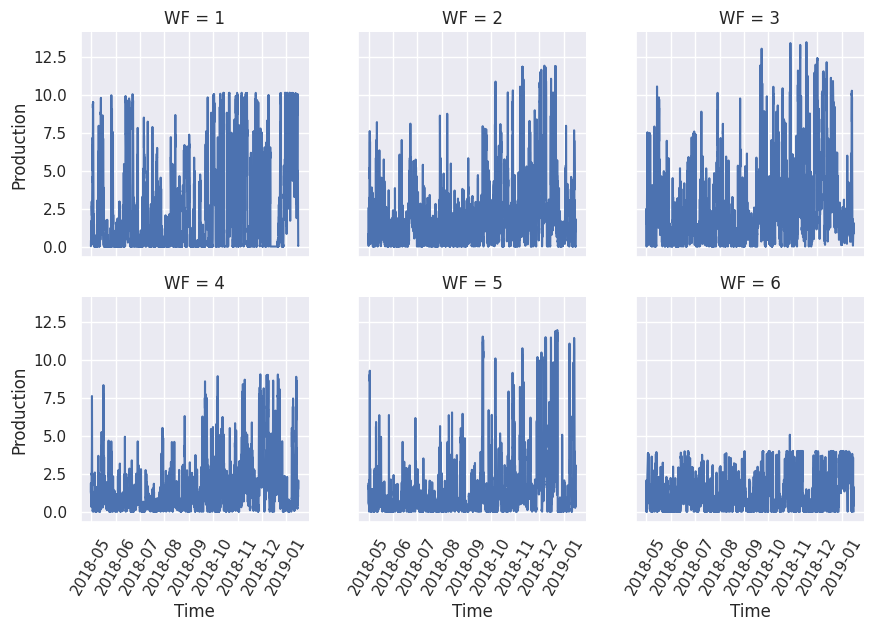

In [84]:
production_vs_time(df)

The following correlation graph confirms the high importance of having computed the wind speed *WS*: it is the feature that correlate the most with the power production.

TypeError: float() argument must be a string or a real number, not 'Timestamp'

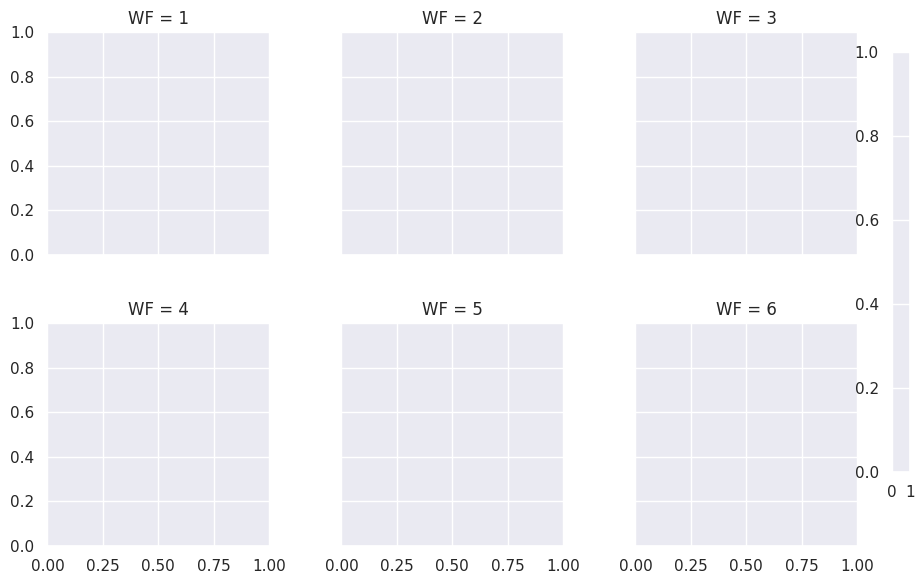

In [132]:
def mean_data(df):
    """ Returns a dataframe containing the mean value for each weather variable across the NWP models """

    nwp_cols = get_nwp_cols(df)
    df_mean = df.drop(columns=nwp_cols)
    for NWP_var in set([col.split('_')[1] for col in nwp_cols]):
        predictors = [col for col in nwp_cols if col.split('_')[1] == NWP_var]
        df_mean.loc[:, NWP_var] = df[predictors].mean(axis=1)
    return df_mean
correlation_graph(mean_data(df))

Furthermore, we can see on the following graph (Production vs WS) that:
 - there is, on average, a linear relationship between the wind speed and power production.
 - the maximal power production capacity is limited differently regarding the wind farms. 
 - WF1 seems to contain a period of forced inactivity (high WS forecasted but 0 MW of power production), which should be excluded from the training set.

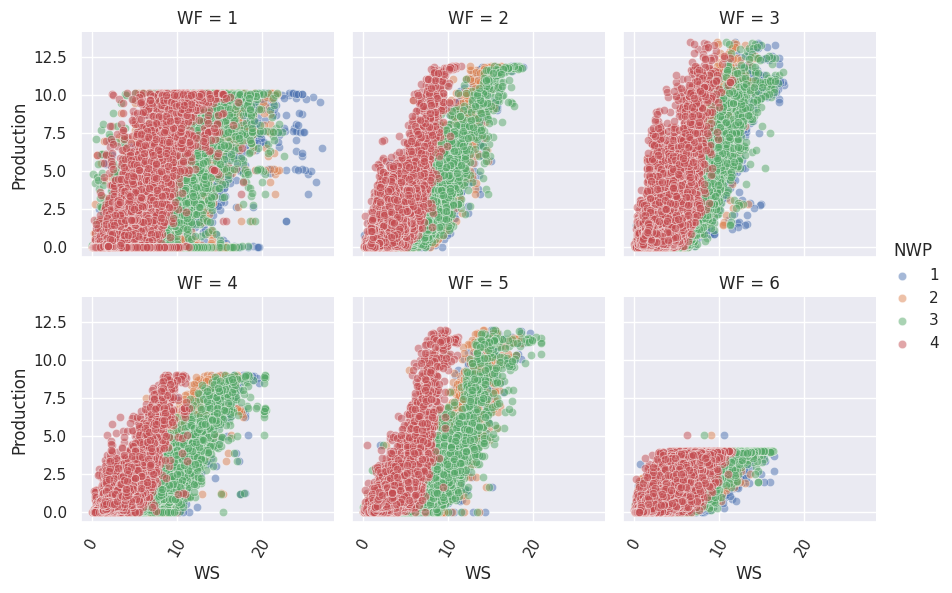

In [103]:
production_vs_feature(df,'WS') # Can be tried also with T, U, V, CLCT, WS, WD variables

**Detection and removal of manual shutdown periods** - When exploring the training dataset, we can find some strange long periods of time where the power production of the wind farm is null whereas the wind speed evolves as normal. One example is shown below :

/home/choclo/Documents/repoCodigosPrediccionAire/env/lib/python3.10/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


<Axes: xlabel='Time'>

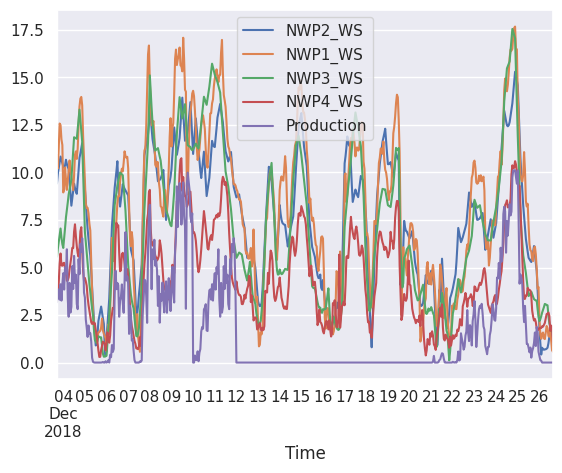

In [104]:
filter = (df.WF==1)&(df.Production.notna())
df[filter][[col for col in df.columns if col.endswith("WS")]+["Time","Production"]].loc[5200:5750].plot(x="Time")

One reasonable explanation for that is that the wind farm is manually turned off, probably for technical maintenance. Similar cases may appear when the wind speed is too high and that the wind farm is turned off for security reasons. However, such examples are too rare in the current dataset to be correctly learned by the models. Thus, I decided to ignore these problematic periods from the learning dataset when the production of a wind farm is null on a consecutive period of more than 24 hours. 

Porportion of manual shutdown period detected in training data (True value)
disabled
False    0.989833
True     0.010167
Name: proportion, dtype: float64


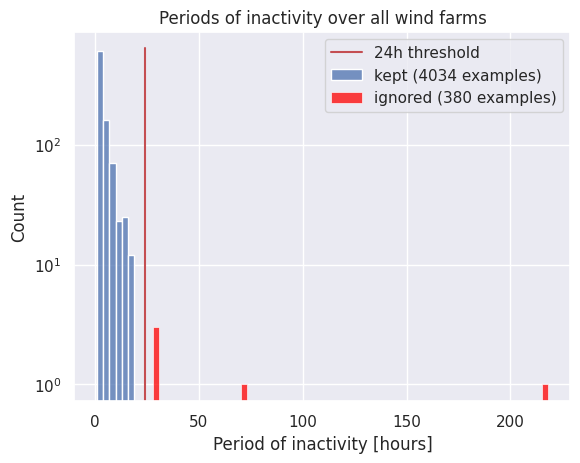

In [107]:
def set_disabled_flag(df, inactivity_periods, delay_threshold):
    """ Set the feature 'disabled' to True in the dataset
    for examples in periods of inactivity
    longer than delay_threshold """
    df = df.copy()
    df.loc[:, 'disabled'] = False
    for period in [p for p in inactivity_periods if p['hours'] > delay_threshold]:
        ID = period['ID_ini']
        df.loc[ID:ID + period['hours'], 'disabled'] = True
    return df

def find_inactivity_periods(df):

    inactivity_periods = []
    for wf_num in df.WF.unique():
        df_wf = df[(df.WF==wf_num)&(df.Production.notna())].Production
        inactivity = 0
        for i in range(len(df_wf)) :
            if df_wf.iloc[i] == 0 :
                if inactivity == 0 :
                    ID_ini = df_wf.index.values[i]
                inactivity += 1
            elif inactivity > 0 :
                inactivity_periods.append({'hours':inactivity, 'ID_ini':ID_ini})
                inactivity = 0
    
    return inactivity_periods
    
delay_threshold = 24
inactivity_periods = find_inactivity_periods(df)
inactivity_histogram(inactivity_periods, delay_threshold)
df = set_disabled_flag(df, inactivity_periods, delay_threshold)
print("Porportion of manual shutdown period detected in training data (True value)")
print(df[df.Production.notna()].disabled.value_counts(normalize=True))

### Data normalization
- Standard normalization (z-score) for weather variables *U*, *V*, *T*, *WS*, *WD*.
- Rescaling weather variable *CLCT* percentage between 0 and 1.

The power production is not rescaled (values lying in [0,14]).

In [109]:
# Data normalization
def normalize_data(df):
    """ Normalize features according to their types """

    df = df.copy()
    nwp_cols = get_nwp_cols(df)

    # CLCT variable is a percentage --> divide it by 100
    nwp_cols_clct = [col for col in nwp_cols if 'CLCT' in col]
    df.loc[:, nwp_cols_clct] /= 100

    # Other variables --> centered and normalized
    nwp_cols_no_clct = [col for col in nwp_cols if 'CLCT' not in col]
    data = df.loc[:, nwp_cols_no_clct]
    df.loc[:, nwp_cols_no_clct] = (data - data.mean()) / data.std()

    return df

df = normalize_data(df)
df.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,...,NWP4_V,NWP2_WS,NWP2_WD,NWP1_WS,NWP1_WD,NWP3_WS,NWP3_WD,NWP4_WS,NWP4_WD,disabled
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,0.103319,1.043255,-2.583740,0.943508,-2.310072,-0.140181,0.828289,...,-1.810975,2.408064,1.294821,2.899447,1.354540,2.395050,1.323865,1.786701,1.216083,False
52,1,2018-05-03 04:00:00,5.11,0.069971,0.843346,-2.670499,0.867615,-2.355027,-0.151106,0.681612,...,-2.099839,2.441591,1.309167,2.957465,1.385261,2.313249,1.345235,2.131617,1.248632,False
53,1,2018-05-03 05:00:00,5.03,0.024369,0.631877,-2.760811,0.791722,-2.399982,-0.162031,0.534936,...,-2.344662,2.478668,1.323286,3.035921,1.416797,2.239185,1.367436,2.381535,1.285669,False
54,1,2018-05-03 06:00:00,7.18,-0.004060,0.447198,-2.763365,0.715829,-2.444938,-0.172955,0.388259,...,-2.679727,2.519209,1.337160,2.993225,1.441314,2.173292,1.390424,2.737533,1.334464,False


## Neural networks models

The following models are trained using time series mini-batches, of shape (mini-batch size, window size, nb_features).
The window size is the number of previous weather forecasts (corresponding to hours) taken into account to compute the power production at time $t$:
- x_t : weather forecasts from time *t-window_size* to *t* (included), which corresponds to *window_size* different weather forecasts.
- y_t : observed power production at time *t*

### Training utilities

In [140]:
# Training functions
def train(model, t_train, x_train, y_train, t_valid=None, x_valid=None, y_valid=None, epochs=None):
    
    validation = True if (x_valid is not None and y_valid is not None) else False
    
    # Make windowed datasets
    dataset_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    dataset_train = dataset_train.shuffle(buffer_size=8192, reshuffle_each_iteration=True).batch(64)
    dataset_valid = None
    if validation :
        dataset_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
        dataset_valid = dataset_valid.batch(4096)
        
    # Compile
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001))

    # Fit 
    callbacks = []
    if validation : 
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.01)]
    if epochs is None :
        epochs = 1000        
    history = model.fit(dataset_train, 
                          validation_data=dataset_valid,
                          epochs=epochs,
                          callbacks=callbacks,
                          verbose=2)
    learning_curves(history)
    
    return history


def cross_validation(model_generator, df, wf_num, **kwargs) :
    
    cross_validations.clear(wf_num)

    df_losses = pd.DataFrame()
    data = WFData(df, wf_num, model_generator.window_size)
    params = {'wf_num':wf_num, 'model_name':model_generator.__class__.__name__}
    
    mlflow.set_experiment('cross_validation')
    with mlflow.start_run():
        mlflow.log_params(params)
        
        #for (t_train, x_train, y_train, t_valid, x_valid, y_valid) in data_wf.split_train_valid_holdout(split=0.7) :
        for (t_train, x_train, y_train, t_valid, x_valid, y_valid) in data.split_train_valid_forward_chaining(nb_steps=3, valid_size=0.1) :
            with mlflow.start_run(nested=True):
                mlflow.log_params(params)

                # Train
                model = model_generator.get()
                history = train(model, t_train, x_train, y_train, t_valid, x_valid, y_valid, **kwargs)
                cross_validations.add(wf_num, history)

                # Predict
                y_train_predict = model.predict(x_train).squeeze()
                y_valid_predict = model.predict(x_valid).squeeze()
                #core.plots.predictions_vs_time(t_train, y_train, y_train_predict, title=f"wf{wf_num}_train_mse={losses['loss']:.2f}")
                predictions_vs_time(t_valid, y_valid, y_valid_predict, title=f"wf{wf_num}_valid")
        
        mlflow.log_metrics(cross_validations.stats_dict(wf_num))
        
        
def cross_validation_all_wf(model_generator, df, only_missing=False, **kwargs):
    
    for wf_num in df.WF.unique() :
        if only_missing is False or (only_missing and wf_num not in cross_validations.results.keys()) :
            cross_validation(model_generator, df, wf_num, **kwargs)
            
def full_dataset_training(model_generator, df, wf_num, nested=False):
    
    data = WFData(df, wf_num, model_generator.window_size)
    params = {'wf_num':wf_num, 'model_name':model_generator.__class__.__name__}
    
    with mlflow.start_run(nested=nested):
        mlflow.log_params(params)
        
        # Train
        t_train, x_train, y_train = data.get_train_data()
        model = model_generator.get()
        epochs = int(cross_validations.stats_dict(wf_num)['epochs']) - 50
        train(model, t_train, x_train, y_train, epochs=epochs)

        # Predict
        t_test, x_test, y_test = data.get_test_data()
        y_test_predict = pd.Series(model.predict(x_test).squeeze(), index=t_test.index, name="Production")
    
    return y_test_predict

### Multi-variable linear regression (baseline)

Let's start with one simple model to **quickly get a performance benchmark for future more complex models**. We choose the **multivariable linear regression**, which takes as input for a given time only the weather forecasts for that particular time (we are thus not considering time series for now).

In [134]:
cross_validations.clear()
class BaselineModel :
    def __init__(self,df) :
        self.window_size = 1 # hour
        self.nb_features = len(core.data.get_nwp_cols(df))
    def get(self) :
        return tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.window_size, self.nb_features)),
            tf.keras.layers.Dense(1, activation='relu')
        ])

See results in the "Overview / Status section".

### Recurrent neural network (RNN)

Now, let's try to catch finer relationships using the fact that training data is made of time series. In the following, we use an RNN model which is trained on 72h of consecutive data. 

In [135]:
cross_validations.clear()
class RNNModel :
    def __init__(self, df) :
        self.window_size = 72 # hours
        self.nb_features = len(core.data.get_nwp_cols(df))
    def get(self):
        return tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.window_size, self.nb_features)),
            tf.keras.layers.GRU(256, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(128, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='relu'),
            tf.keras.layers.Lambda(lambda x: 10*x)
        ])   

See results in the "Overview / Status section".

### Dense neural network (DNN)

In [136]:
cross_validations.clear()
class DNNModel :
    def __init__(self, df) :
        self.window_size = 1 # hours
        self.nb_features = len(get_nwp_cols(df))
    def get(self):
        return tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.window_size, self.nb_features)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='relu'),
            tf.keras.layers.Lambda(lambda x: 10*x)
        ])  

### Experimentation section

/home/choclo/Documents/repoCodigosPrediccionAire/env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-10-20 16:51:49.747860: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/1000


68/68 - 4s - 55ms/step - loss: 2.6530 - val_loss: 7.5331
Epoch 2/1000
68/68 - 0s - 2ms/step - loss: 2.6132 - val_loss: 7.5476
Epoch 3/1000
68/68 - 0s - 1ms/step - loss: 2.5914 - val_loss: 7.5592
Epoch 4/1000
68/68 - 0s - 1ms/step - loss: 2.5787 - val_loss: 7.5708
Epoch 5/1000
68/68 - 0s - 2ms/step - loss: 2.5535 - val_loss: 7.5768
Epoch 6/1000
68/68 - 0s - 1ms/step - loss: 2.5663 - val_loss: 7.5836
Epoch 7/1000
68/68 - 0s - 2ms/step - loss: 2.5528 - val_loss: 7.5914
Epoch 8/1000
68/68 - 0s - 1ms/step - loss: 2.5620 - val_loss: 7.5957
Epoch 9/1000
68/68 - 0s - 2ms/step - loss: 2.5550 - val_loss: 7.5995
Epoch 10/1000
68/68 - 0s - 2ms/step - loss: 2.5604 - val_loss: 7.5985
Epoch 11/1000
68/68 - 0s - 2ms/step - loss: 2.5472 - val_loss: 7.6019
Epoch 12/1000
68/68 - 0s - 2ms/step - loss: 2.5262 - val_loss: 7.5975
Epoch 13/1000
68/68 - 0s - 2ms/step - loss: 2.5364 - val_loss: 7.5912
Epoch 14/1000
68/68 - 0s - 2ms/step - loss: 2.5357 - val_loss: 7.5882
Epoch 15/1000
68/68 - 0s - 1ms/step - los

68/68 - 0s - 2ms/step - loss: 2.5147 - val_loss: 7.5317
Epoch 19/1000


68/68 - 0s - 2ms/step - loss: 2.5197 - val_loss: 7.5104
Epoch 20/1000


68/68 - 0s - 2ms/step - loss: 2.5201 - val_loss: 7.4938
Epoch 21/1000


68/68 - 0s - 2ms/step - loss: 2.5160 - val_loss: 7.4900
Epoch 22/1000


68/68 - 0s - 2ms/step - loss: 2.5054 - val_loss: 7.4679
Epoch 23/1000


68/68 - 0s - 2ms/step - loss: 2.5000 - val_loss: 7.4480
Epoch 24/1000


68/68 - 0s - 2ms/step - loss: 2.5104 - val_loss: 7.4136
Epoch 25/1000


68/68 - 0s - 2ms/step - loss: 2.4989 - val_loss: 7.3630
Epoch 26/1000


68/68 - 0s - 2ms/step - loss: 2.4974 - val_loss: 7.3141
Epoch 27/1000


68/68 - 0s - 2ms/step - loss: 2.5157 - val_loss: 7.2763
Epoch 28/1000


68/68 - 0s - 2ms/step - loss: 2.4930 - val_loss: 7.2508
Epoch 29/1000


68/68 - 0s - 2ms/step - loss: 2.4938 - val_loss: 7.2186
Epoch 30/1000


68/68 - 0s - 2ms/step - loss: 2.4852 - val_loss: 7.1804
Epoch 31/1000


68/68 - 0s - 2ms/step - loss: 2.4694 - val_loss: 7.1153
Epoch 32/1000


68/68 - 0s - 2ms/step - loss: 2.4692 - val_loss: 7.0642
Epoch 33/1000


68/68 - 0s - 2ms/step - loss: 2.4767 - val_loss: 7.0099
Epoch 34/1000


68/68 - 0s - 2ms/step - loss: 2.4851 - val_loss: 6.9834
Epoch 35/1000


68/68 - 0s - 2ms/step - loss: 2.4607 - val_loss: 6.9490
Epoch 36/1000


68/68 - 0s - 2ms/step - loss: 2.4661 - val_loss: 6.9135
Epoch 37/1000


68/68 - 0s - 2ms/step - loss: 2.4665 - val_loss: 6.8801
Epoch 38/1000


68/68 - 0s - 2ms/step - loss: 2.4584 - val_loss: 6.8485
Epoch 39/1000


68/68 - 0s - 2ms/step - loss: 2.4522 - val_loss: 6.8363
Epoch 40/1000


68/68 - 0s - 2ms/step - loss: 2.4491 - val_loss: 6.8006
Epoch 41/1000


68/68 - 0s - 2ms/step - loss: 2.4550 - val_loss: 6.7431
Epoch 42/1000


68/68 - 0s - 2ms/step - loss: 2.4602 - val_loss: 6.7273
Epoch 43/1000


68/68 - 0s - 2ms/step - loss: 2.4488 - val_loss: 6.6993
Epoch 44/1000


68/68 - 0s - 2ms/step - loss: 2.4414 - val_loss: 6.6595
Epoch 45/1000


68/68 - 0s - 2ms/step - loss: 2.4512 - val_loss: 6.6579
Epoch 46/1000


68/68 - 0s - 2ms/step - loss: 2.4370 - val_loss: 6.6017
Epoch 47/1000


68/68 - 0s - 2ms/step - loss: 2.4539 - val_loss: 6.6003
Epoch 48/1000


68/68 - 0s - 2ms/step - loss: 2.4305 - val_loss: 6.5913
Epoch 49/1000


68/68 - 0s - 2ms/step - loss: 2.4502 - val_loss: 6.5638
Epoch 50/1000


68/68 - 0s - 2ms/step - loss: 2.4257 - val_loss: 6.5593
Epoch 51/1000
68/68 - 0s - 2ms/step - loss: 2.4237 - val_loss: 6.5594
Epoch 52/1000
68/68 - 0s - 1ms/step - loss: 2.4465 - val_loss: 6.5661
Epoch 53/1000
68/68 - 0s - 1ms/step - loss: 2.4246 - val_loss: 6.5606
Epoch 54/1000
68/68 - 0s - 1ms/step - loss: 2.4219 - val_loss: 6.5776
Epoch 55/1000
68/68 - 0s - 1ms/step - loss: 2.4268 - val_loss: 6.5863
Epoch 56/1000
68/68 - 0s - 1ms/step - loss: 2.4271 - val_loss: 6.5848
Epoch 57/1000


68/68 - 0s - 2ms/step - loss: 2.4060 - val_loss: 6.5583
Epoch 58/1000
68/68 - 0s - 2ms/step - loss: 2.4151 - val_loss: 6.5671
Epoch 59/1000


68/68 - 0s - 2ms/step - loss: 2.4198 - val_loss: 6.5578
Epoch 60/1000


68/68 - 0s - 2ms/step - loss: 2.4204 - val_loss: 6.5404
Epoch 61/1000
68/68 - 0s - 2ms/step - loss: 2.4125 - val_loss: 6.5422
Epoch 62/1000
68/68 - 0s - 1ms/step - loss: 2.4156 - val_loss: 6.5443
Epoch 63/1000
68/68 - 0s - 2ms/step - loss: 2.4057 - val_loss: 6.5524
Epoch 64/1000
68/68 - 0s - 2ms/step - loss: 2.4025 - val_loss: 6.5533
Epoch 65/1000


68/68 - 0s - 2ms/step - loss: 2.3821 - val_loss: 6.4955
Epoch 66/1000


68/68 - 0s - 2ms/step - loss: 2.3974 - val_loss: 6.4838
Epoch 67/1000


68/68 - 0s - 2ms/step - loss: 2.3947 - val_loss: 6.4766
Epoch 68/1000


68/68 - 0s - 2ms/step - loss: 2.3740 - val_loss: 6.4668
Epoch 69/1000


68/68 - 0s - 2ms/step - loss: 2.3925 - val_loss: 6.4551
Epoch 70/1000
68/68 - 0s - 2ms/step - loss: 2.3833 - val_loss: 6.4655
Epoch 71/1000
68/68 - 0s - 2ms/step - loss: 2.3750 - val_loss: 6.4746
Epoch 72/1000
68/68 - 0s - 1ms/step - loss: 2.3694 - val_loss: 6.4714
Epoch 73/1000
68/68 - 0s - 1ms/step - loss: 2.3794 - val_loss: 6.4720
Epoch 74/1000
68/68 - 0s - 2ms/step - loss: 2.3659 - val_loss: 6.4694
Epoch 75/1000
68/68 - 0s - 2ms/step - loss: 2.3747 - val_loss: 6.4666
Epoch 76/1000
68/68 - 0s - 2ms/step - loss: 2.3532 - val_loss: 6.4623
Epoch 77/1000
68/68 - 0s - 2ms/step - loss: 2.3729 - val_loss: 6.4602
Epoch 78/1000
68/68 - 0s - 2ms/step - loss: 2.3668 - val_loss: 6.4771
Epoch 79/1000
68/68 - 0s - 2ms/step - loss: 2.3589 - val_loss: 6.4574
Epoch 80/1000


68/68 - 0s - 2ms/step - loss: 2.3480 - val_loss: 6.4342
Epoch 81/1000
68/68 - 0s - 2ms/step - loss: 2.3599 - val_loss: 6.4426
Epoch 82/1000


68/68 - 0s - 2ms/step - loss: 2.3498 - val_loss: 6.4127
Epoch 83/1000
68/68 - 0s - 2ms/step - loss: 2.3467 - val_loss: 6.4250
Epoch 84/1000
68/68 - 0s - 2ms/step - loss: 2.3637 - val_loss: 6.4170
Epoch 85/1000
68/68 - 0s - 1ms/step - loss: 2.3531 - val_loss: 6.4323
Epoch 86/1000
68/68 - 0s - 2ms/step - loss: 2.3436 - val_loss: 6.4291
Epoch 87/1000
68/68 - 0s - 2ms/step - loss: 2.3426 - val_loss: 6.4295
Epoch 88/1000
68/68 - 0s - 2ms/step - loss: 2.3358 - val_loss: 6.4185
Epoch 89/1000
68/68 - 0s - 2ms/step - loss: 2.3490 - val_loss: 6.4201
Epoch 90/1000


68/68 - 0s - 2ms/step - loss: 2.3239 - val_loss: 6.4007
Epoch 91/1000


68/68 - 0s - 2ms/step - loss: 2.3297 - val_loss: 6.3993
Epoch 92/1000


68/68 - 0s - 2ms/step - loss: 2.3275 - val_loss: 6.3896
Epoch 93/1000


68/68 - 0s - 2ms/step - loss: 2.3255 - val_loss: 6.3826
Epoch 94/1000
68/68 - 0s - 2ms/step - loss: 2.3288 - val_loss: 6.3852
Epoch 95/1000


68/68 - 0s - 2ms/step - loss: 2.3107 - val_loss: 6.3661
Epoch 96/1000
68/68 - 0s - 2ms/step - loss: 2.3358 - val_loss: 6.3725
Epoch 97/1000


68/68 - 0s - 2ms/step - loss: 2.3116 - val_loss: 6.3386
Epoch 98/1000


68/68 - 0s - 2ms/step - loss: 2.3353 - val_loss: 6.3258
Epoch 99/1000
68/68 - 0s - 2ms/step - loss: 2.3378 - val_loss: 6.3664
Epoch 100/1000
68/68 - 0s - 2ms/step - loss: 2.3014 - val_loss: 6.3493
Epoch 101/1000
68/68 - 0s - 2ms/step - loss: 2.2934 - val_loss: 6.3512
Epoch 102/1000
68/68 - 0s - 2ms/step - loss: 2.3202 - val_loss: 6.3599
Epoch 103/1000
68/68 - 0s - 2ms/step - loss: 2.2919 - val_loss: 6.3472
Epoch 104/1000
68/68 - 0s - 2ms/step - loss: 2.3081 - val_loss: 6.3311
Epoch 105/1000


68/68 - 0s - 2ms/step - loss: 2.2902 - val_loss: 6.3209
Epoch 106/1000


68/68 - 0s - 2ms/step - loss: 2.2837 - val_loss: 6.2946
Epoch 107/1000
68/68 - 0s - 2ms/step - loss: 2.2890 - val_loss: 6.3088
Epoch 108/1000


68/68 - 0s - 2ms/step - loss: 2.2961 - val_loss: 6.2942
Epoch 109/1000
68/68 - 0s - 2ms/step - loss: 2.3002 - val_loss: 6.3207
Epoch 110/1000
68/68 - 0s - 2ms/step - loss: 2.2874 - val_loss: 6.3028
Epoch 111/1000
68/68 - 0s - 2ms/step - loss: 2.2792 - val_loss: 6.3046
Epoch 112/1000
68/68 - 0s - 2ms/step - loss: 2.3013 - val_loss: 6.3100
Epoch 113/1000
68/68 - 0s - 2ms/step - loss: 2.2861 - val_loss: 6.3122
Epoch 114/1000
68/68 - 0s - 2ms/step - loss: 2.2860 - val_loss: 6.3188
Epoch 115/1000
68/68 - 0s - 2ms/step - loss: 2.2735 - val_loss: 6.2978
Epoch 116/1000
68/68 - 0s - 2ms/step - loss: 2.2638 - val_loss: 6.3165
Epoch 117/1000
68/68 - 0s - 2ms/step - loss: 2.2610 - val_loss: 6.3119
Epoch 118/1000


68/68 - 0s - 2ms/step - loss: 2.2679 - val_loss: 6.2739
Epoch 119/1000


68/68 - 0s - 2ms/step - loss: 2.2700 - val_loss: 6.2661
Epoch 120/1000
68/68 - 0s - 2ms/step - loss: 2.2813 - val_loss: 6.2751
Epoch 121/1000


68/68 - 0s - 2ms/step - loss: 2.2645 - val_loss: 6.2655
Epoch 122/1000


68/68 - 0s - 2ms/step - loss: 2.2628 - val_loss: 6.2565
Epoch 123/1000


68/68 - 0s - 2ms/step - loss: 2.2434 - val_loss: 6.2364
Epoch 124/1000


68/68 - 0s - 2ms/step - loss: 2.2728 - val_loss: 6.2211
Epoch 125/1000
68/68 - 0s - 2ms/step - loss: 2.2557 - val_loss: 6.2494
Epoch 126/1000
68/68 - 0s - 2ms/step - loss: 2.2632 - val_loss: 6.2317
Epoch 127/1000
68/68 - 0s - 1ms/step - loss: 2.2615 - val_loss: 6.2419
Epoch 128/1000
68/68 - 0s - 2ms/step - loss: 2.2608 - val_loss: 6.2288
Epoch 129/1000


68/68 - 0s - 2ms/step - loss: 2.2553 - val_loss: 6.2124
Epoch 130/1000


68/68 - 0s - 2ms/step - loss: 2.2491 - val_loss: 6.2036
Epoch 131/1000


68/68 - 0s - 2ms/step - loss: 2.2456 - val_loss: 6.2024
Epoch 132/1000
68/68 - 0s - 2ms/step - loss: 2.2528 - val_loss: 6.2377
Epoch 133/1000
68/68 - 0s - 2ms/step - loss: 2.2602 - val_loss: 6.2267
Epoch 134/1000
68/68 - 0s - 1ms/step - loss: 2.2526 - val_loss: 6.2325
Epoch 135/1000
68/68 - 0s - 2ms/step - loss: 2.2336 - val_loss: 6.2416
Epoch 136/1000
68/68 - 0s - 2ms/step - loss: 2.2349 - val_loss: 6.2305
Epoch 137/1000
68/68 - 0s - 2ms/step - loss: 2.2442 - val_loss: 6.2253
Epoch 138/1000


68/68 - 0s - 2ms/step - loss: 2.2425 - val_loss: 6.2018
Epoch 139/1000


68/68 - 0s - 2ms/step - loss: 2.2330 - val_loss: 6.1788
Epoch 140/1000
68/68 - 0s - 2ms/step - loss: 2.2334 - val_loss: 6.1798
Epoch 141/1000


68/68 - 0s - 2ms/step - loss: 2.2209 - val_loss: 6.1785
Epoch 142/1000


68/68 - 0s - 2ms/step - loss: 2.2366 - val_loss: 6.1692
Epoch 143/1000


68/68 - 0s - 2ms/step - loss: 2.2181 - val_loss: 6.1533
Epoch 144/1000


68/68 - 0s - 2ms/step - loss: 2.2252 - val_loss: 6.1441
Epoch 145/1000


68/68 - 0s - 2ms/step - loss: 2.2139 - val_loss: 6.1118
Epoch 146/1000
68/68 - 0s - 2ms/step - loss: 2.2240 - val_loss: 6.1192
Epoch 147/1000
68/68 - 0s - 1ms/step - loss: 2.2119 - val_loss: 6.1169
Epoch 148/1000


68/68 - 0s - 2ms/step - loss: 2.2231 - val_loss: 6.0998
Epoch 149/1000
68/68 - 0s - 2ms/step - loss: 2.2082 - val_loss: 6.1008
Epoch 150/1000
68/68 - 0s - 2ms/step - loss: 2.2199 - val_loss: 6.1044
Epoch 151/1000


68/68 - 0s - 2ms/step - loss: 2.2174 - val_loss: 6.0773
Epoch 152/1000
68/68 - 0s - 2ms/step - loss: 2.1965 - val_loss: 6.0785
Epoch 153/1000
68/68 - 0s - 2ms/step - loss: 2.2229 - val_loss: 6.0830
Epoch 154/1000
68/68 - 0s - 2ms/step - loss: 2.1982 - val_loss: 6.0794
Epoch 155/1000
68/68 - 0s - 2ms/step - loss: 2.2124 - val_loss: 6.0839
Epoch 156/1000
68/68 - 0s - 2ms/step - loss: 2.2150 - val_loss: 6.0817
Epoch 157/1000
68/68 - 0s - 1ms/step - loss: 2.2089 - val_loss: 6.0806
Epoch 158/1000


68/68 - 0s - 2ms/step - loss: 2.1879 - val_loss: 6.0770
Epoch 159/1000


68/68 - 0s - 2ms/step - loss: 2.1999 - val_loss: 6.0657
Epoch 160/1000


68/68 - 0s - 2ms/step - loss: 2.1841 - val_loss: 6.0354
Epoch 161/1000
68/68 - 0s - 2ms/step - loss: 2.1923 - val_loss: 6.0443
Epoch 162/1000


68/68 - 0s - 2ms/step - loss: 2.1949 - val_loss: 6.0343
Epoch 163/1000
68/68 - 0s - 2ms/step - loss: 2.2009 - val_loss: 6.0602
Epoch 164/1000


68/68 - 0s - 2ms/step - loss: 2.1852 - val_loss: 6.0237
Epoch 165/1000
68/68 - 0s - 2ms/step - loss: 2.1912 - val_loss: 6.0461
Epoch 166/1000


68/68 - 0s - 2ms/step - loss: 2.1911 - val_loss: 6.0217
Epoch 167/1000


68/68 - 0s - 2ms/step - loss: 2.1852 - val_loss: 5.9972
Epoch 168/1000
68/68 - 0s - 2ms/step - loss: 2.1828 - val_loss: 6.0123
Epoch 169/1000
68/68 - 0s - 2ms/step - loss: 2.1753 - val_loss: 5.9978
Epoch 170/1000


68/68 - 0s - 2ms/step - loss: 2.1758 - val_loss: 5.9765
Epoch 171/1000
68/68 - 0s - 2ms/step - loss: 2.1804 - val_loss: 5.9849
Epoch 172/1000
68/68 - 0s - 2ms/step - loss: 2.1836 - val_loss: 6.0137
Epoch 173/1000
68/68 - 0s - 2ms/step - loss: 2.1641 - val_loss: 6.0024
Epoch 174/1000
68/68 - 0s - 2ms/step - loss: 2.1796 - val_loss: 6.0133
Epoch 175/1000
68/68 - 0s - 2ms/step - loss: 2.1803 - val_loss: 5.9933
Epoch 176/1000


68/68 - 0s - 2ms/step - loss: 2.1649 - val_loss: 5.9760
Epoch 177/1000


68/68 - 0s - 2ms/step - loss: 2.1540 - val_loss: 5.9612
Epoch 178/1000


68/68 - 0s - 2ms/step - loss: 2.1718 - val_loss: 5.9474
Epoch 179/1000


68/68 - 0s - 2ms/step - loss: 2.1678 - val_loss: 5.9470
Epoch 180/1000


68/68 - 0s - 2ms/step - loss: 2.1621 - val_loss: 5.9420
Epoch 181/1000


68/68 - 0s - 2ms/step - loss: 2.1664 - val_loss: 5.9326
Epoch 182/1000
68/68 - 0s - 2ms/step - loss: 2.1649 - val_loss: 5.9344
Epoch 183/1000


68/68 - 0s - 2ms/step - loss: 2.1578 - val_loss: 5.9160
Epoch 184/1000


68/68 - 0s - 2ms/step - loss: 2.1591 - val_loss: 5.9130
Epoch 185/1000


68/68 - 0s - 2ms/step - loss: 2.1585 - val_loss: 5.9061
Epoch 186/1000
68/68 - 0s - 2ms/step - loss: 2.1736 - val_loss: 5.9151
Epoch 187/1000
68/68 - 0s - 2ms/step - loss: 2.1588 - val_loss: 5.9250
Epoch 188/1000
68/68 - 0s - 2ms/step - loss: 2.1514 - val_loss: 5.9266
Epoch 189/1000
68/68 - 0s - 2ms/step - loss: 2.1490 - val_loss: 5.9281
Epoch 190/1000
68/68 - 0s - 2ms/step - loss: 2.1580 - val_loss: 5.9156
Epoch 191/1000


68/68 - 0s - 2ms/step - loss: 2.1375 - val_loss: 5.8870
Epoch 192/1000


68/68 - 0s - 2ms/step - loss: 2.1380 - val_loss: 5.8825
Epoch 193/1000


68/68 - 0s - 2ms/step - loss: 2.1440 - val_loss: 5.8573
Epoch 194/1000


68/68 - 0s - 2ms/step - loss: 2.1369 - val_loss: 5.8442
Epoch 195/1000
68/68 - 0s - 2ms/step - loss: 2.1464 - val_loss: 5.8449
Epoch 196/1000
68/68 - 0s - 2ms/step - loss: 2.1366 - val_loss: 5.8537
Epoch 197/1000


68/68 - 0s - 2ms/step - loss: 2.1389 - val_loss: 5.8279
Epoch 198/1000
68/68 - 0s - 2ms/step - loss: 2.1466 - val_loss: 5.8317
Epoch 199/1000
68/68 - 0s - 2ms/step - loss: 2.1495 - val_loss: 5.8347
Epoch 200/1000
68/68 - 0s - 2ms/step - loss: 2.1425 - val_loss: 5.8353
Epoch 201/1000
68/68 - 0s - 2ms/step - loss: 2.1403 - val_loss: 5.8471
Epoch 202/1000
68/68 - 0s - 2ms/step - loss: 2.1275 - val_loss: 5.8521
Epoch 203/1000
68/68 - 0s - 2ms/step - loss: 2.1295 - val_loss: 5.8702
Epoch 204/1000
68/68 - 0s - 2ms/step - loss: 2.1390 - val_loss: 5.8403
Epoch 205/1000


68/68 - 0s - 2ms/step - loss: 2.1278 - val_loss: 5.8142
Epoch 206/1000


68/68 - 0s - 2ms/step - loss: 2.1218 - val_loss: 5.7935
Epoch 207/1000


68/68 - 0s - 2ms/step - loss: 2.1208 - val_loss: 5.7621
Epoch 208/1000


68/68 - 0s - 2ms/step - loss: 2.1253 - val_loss: 5.7404
Epoch 209/1000


68/68 - 0s - 2ms/step - loss: 2.1252 - val_loss: 5.7363
Epoch 210/1000


68/68 - 0s - 2ms/step - loss: 2.1221 - val_loss: 5.7254
Epoch 211/1000
68/68 - 0s - 2ms/step - loss: 2.1206 - val_loss: 5.7359
Epoch 212/1000


68/68 - 0s - 2ms/step - loss: 2.1162 - val_loss: 5.7199
Epoch 213/1000


68/68 - 0s - 2ms/step - loss: 2.1105 - val_loss: 5.6935
Epoch 214/1000


68/68 - 0s - 2ms/step - loss: 2.1177 - val_loss: 5.6723
Epoch 215/1000
68/68 - 0s - 2ms/step - loss: 2.1029 - val_loss: 5.6739
Epoch 216/1000
68/68 - 0s - 1ms/step - loss: 2.1155 - val_loss: 5.6735
Epoch 217/1000
68/68 - 0s - 2ms/step - loss: 2.1145 - val_loss: 5.6776
Epoch 218/1000


68/68 - 0s - 2ms/step - loss: 2.1141 - val_loss: 5.6571
Epoch 219/1000
68/68 - 0s - 2ms/step - loss: 2.1030 - val_loss: 5.6697
Epoch 220/1000
68/68 - 0s - 2ms/step - loss: 2.1193 - val_loss: 5.6803
Epoch 221/1000
68/68 - 0s - 2ms/step - loss: 2.1074 - val_loss: 5.6669
Epoch 222/1000
68/68 - 0s - 2ms/step - loss: 2.0979 - val_loss: 5.6766
Epoch 223/1000
68/68 - 0s - 2ms/step - loss: 2.0991 - val_loss: 5.6933
Epoch 224/1000
68/68 - 0s - 2ms/step - loss: 2.0982 - val_loss: 5.7004
Epoch 225/1000
68/68 - 0s - 2ms/step - loss: 2.1156 - val_loss: 5.6680
Epoch 226/1000
68/68 - 0s - 2ms/step - loss: 2.1175 - val_loss: 5.6718
Epoch 227/1000


68/68 - 0s - 2ms/step - loss: 2.1022 - val_loss: 5.6554
Epoch 228/1000


68/68 - 0s - 2ms/step - loss: 2.1024 - val_loss: 5.6483
Epoch 229/1000


68/68 - 0s - 2ms/step - loss: 2.1044 - val_loss: 5.6342
Epoch 230/1000
68/68 - 0s - 2ms/step - loss: 2.1086 - val_loss: 5.6585
Epoch 231/1000
68/68 - 0s - 1ms/step - loss: 2.0978 - val_loss: 5.6536
Epoch 232/1000
68/68 - 0s - 1ms/step - loss: 2.0901 - val_loss: 5.6701
Epoch 233/1000
68/68 - 0s - 1ms/step - loss: 2.1101 - val_loss: 5.6348
Epoch 234/1000


68/68 - 0s - 2ms/step - loss: 2.0923 - val_loss: 5.6327
Epoch 235/1000
68/68 - 0s - 2ms/step - loss: 2.0996 - val_loss: 5.6377
Epoch 236/1000
68/68 - 0s - 2ms/step - loss: 2.0825 - val_loss: 5.6390
Epoch 237/1000
68/68 - 0s - 1ms/step - loss: 2.0795 - val_loss: 5.6560
Epoch 238/1000
68/68 - 0s - 2ms/step - loss: 2.0927 - val_loss: 5.6703
Epoch 239/1000
68/68 - 0s - 2ms/step - loss: 2.0802 - val_loss: 5.6731
Epoch 240/1000
68/68 - 0s - 1ms/step - loss: 2.0842 - val_loss: 5.6562
Epoch 241/1000
68/68 - 0s - 1ms/step - loss: 2.0737 - val_loss: 5.6605
Epoch 242/1000
68/68 - 0s - 2ms/step - loss: 2.0748 - val_loss: 5.6343
Epoch 243/1000


68/68 - 0s - 2ms/step - loss: 2.0862 - val_loss: 5.6314
Epoch 244/1000
68/68 - 0s - 2ms/step - loss: 2.0897 - val_loss: 5.6318
Epoch 245/1000
68/68 - 0s - 1ms/step - loss: 2.0799 - val_loss: 5.6327
Epoch 246/1000
68/68 - 0s - 1ms/step - loss: 2.0700 - val_loss: 5.6489
Epoch 247/1000
68/68 - 0s - 2ms/step - loss: 2.0811 - val_loss: 5.6518
Epoch 248/1000
68/68 - 0s - 1ms/step - loss: 2.0857 - val_loss: 5.6413
Epoch 249/1000
68/68 - 0s - 2ms/step - loss: 2.0743 - val_loss: 5.6453
Epoch 250/1000


68/68 - 0s - 2ms/step - loss: 2.0729 - val_loss: 5.6262
Epoch 251/1000


68/68 - 0s - 2ms/step - loss: 2.0772 - val_loss: 5.6257
Epoch 252/1000


68/68 - 0s - 2ms/step - loss: 2.0541 - val_loss: 5.6018
Epoch 253/1000


68/68 - 0s - 2ms/step - loss: 2.0687 - val_loss: 5.5485
Epoch 254/1000


68/68 - 0s - 2ms/step - loss: 2.0644 - val_loss: 5.5332
Epoch 255/1000
68/68 - 0s - 2ms/step - loss: 2.0757 - val_loss: 5.5570
Epoch 256/1000
68/68 - 0s - 1ms/step - loss: 2.0634 - val_loss: 5.5585
Epoch 257/1000
68/68 - 0s - 2ms/step - loss: 2.0756 - val_loss: 5.5469
Epoch 258/1000
68/68 - 0s - 2ms/step - loss: 2.0757 - val_loss: 5.5698
Epoch 259/1000
68/68 - 0s - 2ms/step - loss: 2.0671 - val_loss: 5.5534
Epoch 260/1000
68/68 - 0s - 2ms/step - loss: 2.0615 - val_loss: 5.5399
Epoch 261/1000


68/68 - 0s - 2ms/step - loss: 2.0509 - val_loss: 5.5149
Epoch 262/1000
68/68 - 0s - 2ms/step - loss: 2.0657 - val_loss: 5.5185
Epoch 263/1000


68/68 - 0s - 2ms/step - loss: 2.0581 - val_loss: 5.5011
Epoch 264/1000
68/68 - 0s - 2ms/step - loss: 2.0526 - val_loss: 5.5020
Epoch 265/1000


68/68 - 0s - 2ms/step - loss: 2.0525 - val_loss: 5.4887
Epoch 266/1000
68/68 - 0s - 2ms/step - loss: 2.0665 - val_loss: 5.5058
Epoch 267/1000
68/68 - 0s - 2ms/step - loss: 2.0566 - val_loss: 5.5129
Epoch 268/1000


68/68 - 0s - 2ms/step - loss: 2.0514 - val_loss: 5.4761
Epoch 269/1000
68/68 - 0s - 2ms/step - loss: 2.0637 - val_loss: 5.5140
Epoch 270/1000
68/68 - 0s - 1ms/step - loss: 2.0512 - val_loss: 5.4889
Epoch 271/1000
68/68 - 0s - 2ms/step - loss: 2.0554 - val_loss: 5.4787
Epoch 272/1000


68/68 - 0s - 2ms/step - loss: 2.0469 - val_loss: 5.4736
Epoch 273/1000
68/68 - 0s - 2ms/step - loss: 2.0555 - val_loss: 5.4832
Epoch 274/1000
68/68 - 0s - 2ms/step - loss: 2.0513 - val_loss: 5.4809
Epoch 275/1000
68/68 - 0s - 2ms/step - loss: 2.0521 - val_loss: 5.4969
Epoch 276/1000
68/68 - 0s - 2ms/step - loss: 2.0569 - val_loss: 5.4782
Epoch 277/1000


68/68 - 0s - 2ms/step - loss: 2.0471 - val_loss: 5.4718
Epoch 278/1000
68/68 - 0s - 2ms/step - loss: 2.0418 - val_loss: 5.4727
Epoch 279/1000


68/68 - 0s - 2ms/step - loss: 2.0461 - val_loss: 5.4612
Epoch 280/1000


68/68 - 0s - 2ms/step - loss: 2.0398 - val_loss: 5.4603
Epoch 281/1000
68/68 - 0s - 1ms/step - loss: 2.0342 - val_loss: 5.4721
Epoch 282/1000


68/68 - 0s - 2ms/step - loss: 2.0301 - val_loss: 5.4503
Epoch 283/1000


68/68 - 0s - 2ms/step - loss: 2.0411 - val_loss: 5.4497
Epoch 284/1000


68/68 - 0s - 2ms/step - loss: 2.0373 - val_loss: 5.4277
Epoch 285/1000


68/68 - 0s - 2ms/step - loss: 2.0351 - val_loss: 5.4079
Epoch 286/1000


68/68 - 0s - 2ms/step - loss: 2.0303 - val_loss: 5.4049
Epoch 287/1000


68/68 - 0s - 2ms/step - loss: 2.0375 - val_loss: 5.3840
Epoch 288/1000
68/68 - 0s - 2ms/step - loss: 2.0472 - val_loss: 5.3977
Epoch 289/1000


68/68 - 0s - 2ms/step - loss: 2.0379 - val_loss: 5.3828
Epoch 290/1000
68/68 - 0s - 2ms/step - loss: 2.0422 - val_loss: 5.4005
Epoch 291/1000


68/68 - 0s - 2ms/step - loss: 2.0340 - val_loss: 5.3736
Epoch 292/1000
68/68 - 0s - 2ms/step - loss: 2.0334 - val_loss: 5.3790
Epoch 293/1000


68/68 - 0s - 2ms/step - loss: 2.0277 - val_loss: 5.3530
Epoch 294/1000
68/68 - 0s - 2ms/step - loss: 2.0338 - val_loss: 5.3674
Epoch 295/1000
68/68 - 0s - 1ms/step - loss: 2.0309 - val_loss: 5.3547
Epoch 296/1000


68/68 - 0s - 2ms/step - loss: 2.0234 - val_loss: 5.3388
Epoch 297/1000


68/68 - 0s - 2ms/step - loss: 2.0255 - val_loss: 5.3342
Epoch 298/1000


68/68 - 0s - 2ms/step - loss: 2.0345 - val_loss: 5.3259
Epoch 299/1000
68/68 - 0s - 2ms/step - loss: 2.0209 - val_loss: 5.3277
Epoch 300/1000


68/68 - 0s - 2ms/step - loss: 2.0262 - val_loss: 5.3122
Epoch 301/1000


68/68 - 0s - 2ms/step - loss: 2.0249 - val_loss: 5.3057
Epoch 302/1000
68/68 - 0s - 2ms/step - loss: 2.0170 - val_loss: 5.3288
Epoch 303/1000
68/68 - 0s - 2ms/step - loss: 2.0272 - val_loss: 5.3178
Epoch 304/1000
68/68 - 0s - 2ms/step - loss: 2.0222 - val_loss: 5.3284
Epoch 305/1000
68/68 - 0s - 2ms/step - loss: 2.0193 - val_loss: 5.3477
Epoch 306/1000
68/68 - 0s - 2ms/step - loss: 2.0230 - val_loss: 5.3492
Epoch 307/1000
68/68 - 0s - 2ms/step - loss: 2.0262 - val_loss: 5.3367
Epoch 308/1000
68/68 - 0s - 1ms/step - loss: 2.0178 - val_loss: 5.3153
Epoch 309/1000


68/68 - 0s - 2ms/step - loss: 2.0155 - val_loss: 5.2989
Epoch 310/1000


68/68 - 0s - 2ms/step - loss: 2.0266 - val_loss: 5.2846
Epoch 311/1000


68/68 - 0s - 2ms/step - loss: 2.0095 - val_loss: 5.2735
Epoch 312/1000


68/68 - 0s - 2ms/step - loss: 2.0090 - val_loss: 5.2579
Epoch 313/1000
68/68 - 0s - 2ms/step - loss: 2.0128 - val_loss: 5.2711
Epoch 314/1000
68/68 - 0s - 2ms/step - loss: 2.0087 - val_loss: 5.2601
Epoch 315/1000
68/68 - 0s - 1ms/step - loss: 2.0098 - val_loss: 5.2643
Epoch 316/1000
68/68 - 0s - 2ms/step - loss: 2.0177 - val_loss: 5.2754
Epoch 317/1000
68/68 - 0s - 1ms/step - loss: 2.0237 - val_loss: 5.2848
Epoch 318/1000
68/68 - 0s - 2ms/step - loss: 2.0131 - val_loss: 5.2778
Epoch 319/1000
68/68 - 0s - 1ms/step - loss: 2.0144 - val_loss: 5.2662
Epoch 320/1000


68/68 - 0s - 2ms/step - loss: 2.0097 - val_loss: 5.2495
Epoch 321/1000
68/68 - 0s - 2ms/step - loss: 2.0048 - val_loss: 5.2507
Epoch 322/1000
68/68 - 0s - 1ms/step - loss: 2.0183 - val_loss: 5.2517
Epoch 323/1000


68/68 - 0s - 2ms/step - loss: 2.0017 - val_loss: 5.2320
Epoch 324/1000
68/68 - 0s - 2ms/step - loss: 2.0031 - val_loss: 5.2426
Epoch 325/1000
68/68 - 0s - 2ms/step - loss: 2.0108 - val_loss: 5.2607
Epoch 326/1000
68/68 - 0s - 2ms/step - loss: 2.0026 - val_loss: 5.2715
Epoch 327/1000
68/68 - 0s - 2ms/step - loss: 2.0030 - val_loss: 5.2647
Epoch 328/1000


68/68 - 0s - 2ms/step - loss: 1.9894 - val_loss: 5.2212
Epoch 329/1000
68/68 - 0s - 2ms/step - loss: 2.0029 - val_loss: 5.2283
Epoch 330/1000
68/68 - 0s - 2ms/step - loss: 1.9959 - val_loss: 5.2247
Epoch 331/1000


68/68 - 0s - 2ms/step - loss: 1.9848 - val_loss: 5.2017
Epoch 332/1000
68/68 - 0s - 2ms/step - loss: 2.0084 - val_loss: 5.2089
Epoch 333/1000
68/68 - 0s - 1ms/step - loss: 1.9940 - val_loss: 5.2065
Epoch 334/1000


68/68 - 0s - 2ms/step - loss: 2.0039 - val_loss: 5.1982
Epoch 335/1000
68/68 - 0s - 2ms/step - loss: 1.9911 - val_loss: 5.2149
Epoch 336/1000
68/68 - 0s - 2ms/step - loss: 2.0058 - val_loss: 5.2361
Epoch 337/1000
68/68 - 0s - 2ms/step - loss: 1.9882 - val_loss: 5.2249
Epoch 338/1000
68/68 - 0s - 2ms/step - loss: 1.9907 - val_loss: 5.2120
Epoch 339/1000


68/68 - 0s - 2ms/step - loss: 2.0019 - val_loss: 5.1975
Epoch 340/1000


68/68 - 0s - 2ms/step - loss: 1.9960 - val_loss: 5.1854
Epoch 341/1000


68/68 - 0s - 2ms/step - loss: 1.9950 - val_loss: 5.1545
Epoch 342/1000


68/68 - 0s - 2ms/step - loss: 1.9914 - val_loss: 5.1445
Epoch 343/1000
68/68 - 0s - 2ms/step - loss: 1.9923 - val_loss: 5.1467
Epoch 344/1000
68/68 - 0s - 2ms/step - loss: 1.9906 - val_loss: 5.1483
Epoch 345/1000
68/68 - 0s - 2ms/step - loss: 1.9772 - val_loss: 5.1528
Epoch 346/1000
68/68 - 0s - 2ms/step - loss: 1.9912 - val_loss: 5.1513
Epoch 347/1000


68/68 - 0s - 2ms/step - loss: 1.9920 - val_loss: 5.1400
Epoch 348/1000


68/68 - 0s - 2ms/step - loss: 1.9774 - val_loss: 5.1335
Epoch 349/1000


68/68 - 0s - 2ms/step - loss: 1.9938 - val_loss: 5.1282
Epoch 350/1000
68/68 - 0s - 2ms/step - loss: 1.9893 - val_loss: 5.1380
Epoch 351/1000


68/68 - 0s - 2ms/step - loss: 1.9891 - val_loss: 5.1228
Epoch 352/1000
68/68 - 0s - 2ms/step - loss: 1.9820 - val_loss: 5.1313
Epoch 353/1000
68/68 - 0s - 2ms/step - loss: 1.9801 - val_loss: 5.1393
Epoch 354/1000
68/68 - 0s - 1ms/step - loss: 1.9903 - val_loss: 5.1396
Epoch 355/1000
68/68 - 0s - 2ms/step - loss: 1.9832 - val_loss: 5.1312
Epoch 356/1000


68/68 - 0s - 2ms/step - loss: 1.9781 - val_loss: 5.1210
Epoch 357/1000


68/68 - 0s - 2ms/step - loss: 1.9750 - val_loss: 5.1038
Epoch 358/1000


68/68 - 0s - 2ms/step - loss: 1.9847 - val_loss: 5.0917
Epoch 359/1000


68/68 - 0s - 2ms/step - loss: 1.9789 - val_loss: 5.0815
Epoch 360/1000


68/68 - 0s - 2ms/step - loss: 1.9762 - val_loss: 5.0765
Epoch 361/1000
68/68 - 0s - 2ms/step - loss: 1.9786 - val_loss: 5.0920
Epoch 362/1000
68/68 - 0s - 2ms/step - loss: 1.9879 - val_loss: 5.0888
Epoch 363/1000


68/68 - 0s - 2ms/step - loss: 1.9743 - val_loss: 5.0591
Epoch 364/1000
68/68 - 0s - 2ms/step - loss: 1.9776 - val_loss: 5.0727
Epoch 365/1000
68/68 - 0s - 2ms/step - loss: 1.9849 - val_loss: 5.0803
Epoch 366/1000
68/68 - 0s - 2ms/step - loss: 1.9755 - val_loss: 5.1042
Epoch 367/1000
68/68 - 0s - 2ms/step - loss: 1.9718 - val_loss: 5.1141
Epoch 368/1000
68/68 - 0s - 2ms/step - loss: 1.9742 - val_loss: 5.1077
Epoch 369/1000
68/68 - 0s - 2ms/step - loss: 1.9674 - val_loss: 5.1078
Epoch 370/1000
68/68 - 0s - 2ms/step - loss: 1.9765 - val_loss: 5.1222
Epoch 371/1000
68/68 - 0s - 2ms/step - loss: 1.9743 - val_loss: 5.1049
Epoch 372/1000
68/68 - 0s - 2ms/step - loss: 1.9754 - val_loss: 5.1010
Epoch 373/1000
68/68 - 0s - 2ms/step - loss: 1.9695 - val_loss: 5.1072
Epoch 374/1000
68/68 - 0s - 2ms/step - loss: 1.9648 - val_loss: 5.1150
Epoch 375/1000
68/68 - 0s - 2ms/step - loss: 1.9745 - val_loss: 5.1152
Epoch 376/1000
68/68 - 0s - 2ms/step - loss: 1.9791 - val_loss: 5.1216
Epoch 377/1000
68/68 

68/68 - 0s - 2ms/step - loss: 1.9667 - val_loss: 5.0529
Epoch 385/1000
68/68 - 0s - 2ms/step - loss: 1.9643 - val_loss: 5.0577
Epoch 386/1000
68/68 - 0s - 2ms/step - loss: 1.9608 - val_loss: 5.0679
Epoch 387/1000
68/68 - 0s - 1ms/step - loss: 1.9736 - val_loss: 5.0880
Epoch 388/1000
68/68 - 0s - 1ms/step - loss: 1.9583 - val_loss: 5.0832
Epoch 389/1000
68/68 - 0s - 2ms/step - loss: 1.9704 - val_loss: 5.0683
Epoch 390/1000
68/68 - 0s - 2ms/step - loss: 1.9632 - val_loss: 5.0725
Epoch 391/1000
68/68 - 0s - 2ms/step - loss: 1.9616 - val_loss: 5.0738
Epoch 392/1000
68/68 - 0s - 2ms/step - loss: 1.9572 - val_loss: 5.0731
Epoch 393/1000
68/68 - 0s - 2ms/step - loss: 1.9697 - val_loss: 5.0705
Epoch 394/1000
68/68 - 0s - 2ms/step - loss: 1.9565 - val_loss: 5.0722
Epoch 395/1000
68/68 - 0s - 2ms/step - loss: 1.9648 - val_loss: 5.0578
Epoch 396/1000
68/68 - 0s - 2ms/step - loss: 1.9571 - val_loss: 5.0719
Epoch 397/1000
68/68 - 0s - 2ms/step - loss: 1.9534 - val_loss: 5.0946
Epoch 398/1000
68/68 

NameError: name 'save_plot' is not defined

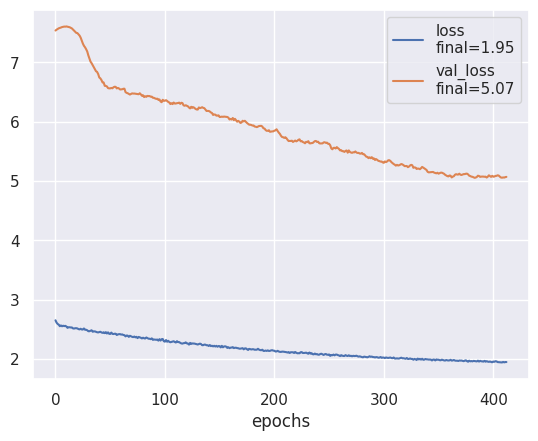

In [146]:
# EXPRIMENTATION CELL
# ===================
model_generator = DNNModel(df)
cross_validation(model_generator, df, wf_num=5)
#cross_validation_all_wf(model_generator, df, only_missing=True)
print(cross_validations.status())

In [144]:
### Final model evaluation
### ======================

from core import training
# Full training
mlflow.set_experiment('full')
with mlflow.start_run() :
    mlflow.log_params({'model_name':model_generator.__class__.__name__})
    predictions = []
    for wf_num in df.WF.unique() :
        y_test_predict = full_dataset_training(model_generator, df, wf_num, nested=True)
        predictions.append(y_test_predict)
    save_predictions(predictions)
    save_text(cross_validations.status(),'cross_validation.txt')
    mlflow.log_metrics(cross_validations.global_stats())

ModuleNotFoundError: No module named 'mpld3'